# 아파트 실거래가 로딩
- 시군구를 구, 동으로 분리
- 전용면적 -> 평 -> 평형
- 계약년월 -> 계약년, 계약월 분리
- 계약년월 + 계약일 -> datetime 변환 -> 계약요일 추출
- 칼럼 삭제 (본번, 부번)
- 결측치 처리
- EDA실시 (통계, 시각화)
- 실거래가 회귀분석

In [1]:
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')

import pandas as pd

apt_price = pd.read_csv(
    '../20220906 - 기술통계, 결측치 처리, 그룹핑/apt_price_2022.csv',
    encoding='cp949',
    skiprows=15,
    thousands=','
)

apt_price

,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명,해제사유발생일,거래유형,중개사소재지
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성아파트1동~8동,79.97,202109,2,220000,2,1987.0,언주로 3,NaN,-,-
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성아파트1동~8동,79.97,202112,4,215000,3,1987.0,언주로 3,NaN,중개거래,서울 강남구
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성아파트1동~8동,79.97,202204,12,220000,4,1987.0,언주로 3,NaN,중개거래,서울 강남구
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성아파트1동~8동,79.97,202204,21,220000,2,1987.0,언주로 3,NaN,중개거래,서울 강남구
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성아파트1동~8동,79.97,202205,27,216000,2,1987.0,언주로 3,NaN,중개거래,서울 강남구
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16994,서울특별시 중랑구 중화동,450,450.0,0.0,한신아파트(103~109),59.76,202207,20,74000,3,1997.0,동일로 752,NaN,중개거래,서울 중랑구
16995,서울특별시 중랑구 중화동,450,450.0,0.0,한신아파트(103~109),84.03,202207,27,91500,12,1997.0,동일로 752,NaN,중개거래,서울 중랑구
16996,서울특별시 중랑구 중화동,274-51,274.0,51.0,한영(101),84.69,202111,4,50000,2,2003.0,동일로144길 74,NaN,중개거래,"서울 송파구, 서울 중랑구"
16997,서울특별시 중랑구 중화동,274-51,274.0,51.0,한영(101),84.69,202204,9,49900,7,2003.0,동일로144길 74,NaN,중개거래,서울 중랑구


In [2]:
# 시군구를 구,동으로 분리
apt_price['구'] = apt_price['시군구'].str.split().str[1]
apt_price['동'] = apt_price['시군구'].str.split().str[2]

# 전용면적을 평형으로 변환
apt_price['평'] = round(apt_price['전용면적(㎡)'] / 3.03, 1)
apt_price['평형'] = pd.cut(
    apt_price['평'],
    bins=[0, 10, 20, 30, 40, 50, 100000],
    labels='10평이하,10평대,20평대,30평대,40평대,40평이상'.split(',')
)
# 거래금액 단위를 억원으로 변환
apt_price["거래금액_억원"] = apt_price["거래금액(만원)"] / 10000

# 계약년월 -> 계약년, 계약월로 분리
apt_price["계약년"] = apt_price["계약년월"] // 100 
apt_price["계약월"] = apt_price["계약년월"] % 100 

# 계약요일
apt_price['계약요일'] = pd.to_datetime(
    apt_price['계약년월'].astype(str) + apt_price['계약일'].astype(str),
    format='%Y%m%d'
).dt.dayofweek

apt_price.head()

,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,...,거래유형,중개사소재지,구,동,평,평형,거래금액_억원,계약년,계약월,계약요일
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성아파트1동~8동,79.97,202109,2,220000,2,...,-,-,강남구,개포동,26.4,20평대,22.0,2021,9,3
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성아파트1동~8동,79.97,202112,4,215000,3,...,중개거래,서울 강남구,강남구,개포동,26.4,20평대,21.5,2021,12,5
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성아파트1동~8동,79.97,202204,12,220000,4,...,중개거래,서울 강남구,강남구,개포동,26.4,20평대,22.0,2022,4,1
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성아파트1동~8동,79.97,202204,21,220000,2,...,중개거래,서울 강남구,강남구,개포동,26.4,20평대,22.0,2022,4,3
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성아파트1동~8동,79.97,202205,27,216000,2,...,중개거래,서울 강남구,강남구,개포동,26.4,20평대,21.6,2022,5,4


In [3]:
apt_price.drop(columns=['본번', '부번'], inplace=True)

apt_price.head()

,시군구,번지,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명,...,거래유형,중개사소재지,구,동,평,평형,거래금액_억원,계약년,계약월,계약요일
0,서울특별시 강남구 개포동,658-1,개포6차우성아파트1동~8동,79.97,202109,2,220000,2,1987.0,언주로 3,...,-,-,강남구,개포동,26.4,20평대,22.0,2021,9,3
1,서울특별시 강남구 개포동,658-1,개포6차우성아파트1동~8동,79.97,202112,4,215000,3,1987.0,언주로 3,...,중개거래,서울 강남구,강남구,개포동,26.4,20평대,21.5,2021,12,5
2,서울특별시 강남구 개포동,658-1,개포6차우성아파트1동~8동,79.97,202204,12,220000,4,1987.0,언주로 3,...,중개거래,서울 강남구,강남구,개포동,26.4,20평대,22.0,2022,4,1
3,서울특별시 강남구 개포동,658-1,개포6차우성아파트1동~8동,79.97,202204,21,220000,2,1987.0,언주로 3,...,중개거래,서울 강남구,강남구,개포동,26.4,20평대,22.0,2022,4,3
4,서울특별시 강남구 개포동,658-1,개포6차우성아파트1동~8동,79.97,202205,27,216000,2,1987.0,언주로 3,...,중개거래,서울 강남구,강남구,개포동,26.4,20평대,21.6,2022,5,4


In [4]:
apt_price.shape

(16999, 21)

In [5]:
apt_price.isna().sum()

시군구             0
번지              4
단지명             0
전용면적(㎡)         0
계약년월            0
계약일             0
거래금액(만원)        0
층               0
건축년도            2
도로명             0
해제사유발생일     16328
거래유형            0
중개사소재지          0
구               0
동               0
평               0
평형              0
거래금액_억원         0
계약년             0
계약월             0
계약요일            0
dtype: int64

In [6]:
apt_price['번지'] = apt_price['번지'].fillna('')
apt_price['건축년도'] = apt_price['건축년도'].fillna('')
# apt_price['해제사유발생일'] = apt_price['해제사유발생일'].fillna('')

## 구별 계약건수

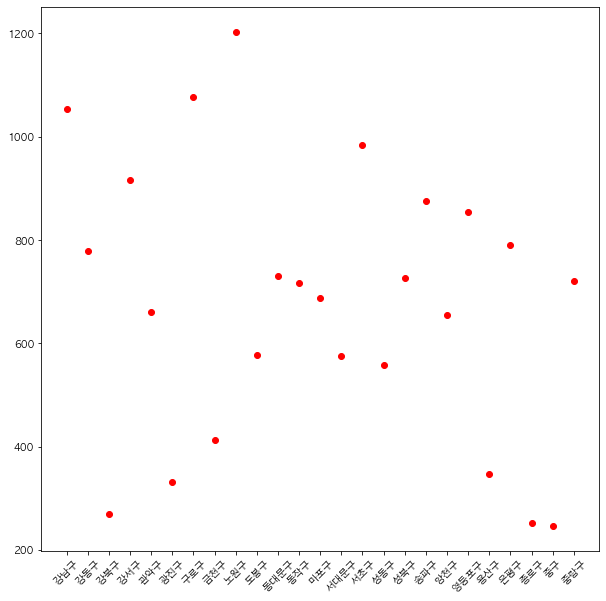

In [7]:
구별계약건수 = apt_price.groupby('구')[['층']].count()

plt.figure(figsize=(10,10))
plt.xticks(rotation=45)

plt.plot(
    구별계약건수.index,
    구별계약건수['층'],
    'ro'
)

## 계약년월별 구별 거래건수

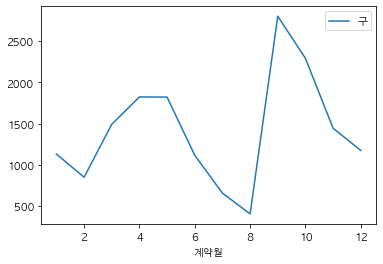

In [9]:
계약년월별구별거래건수 = apt_price.groupby('계약월')[['구']].count().plot()


## 계약년월별 구별 평균 거래 가격

In [10]:
계약년월별구별평균거래가격 = apt_price.groupby('계약월')[['구', '거래금액_억원']].mean()

<AxesSubplot:xlabel='계약월'>

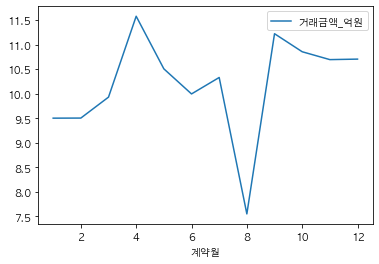

In [11]:
계약년월별구별평균거래가격.plot()

## 계약년월별 거래취소건수

In [30]:
거래취소 = apt_price.loc[apt_price['해제사유발생일'] == '']
계약년월별거래취소건수 = 거래취소.groupby('계약년월')[['해제사유발생일']].count()

<AxesSubplot:xlabel='계약년월'>

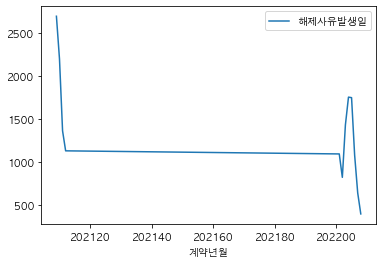

In [31]:
계약년월별거래취소건수.plot()

## 구별 거래취소건수

In [32]:
구별거래취소건수 = 거래취소.groupby('구')[['해제사유발생일']].count()

<AxesSubplot:xlabel='구'>

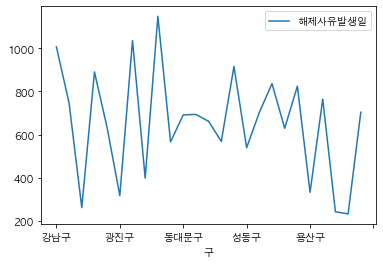

In [33]:
구별거래취소건수.plot()

In [21]:
# 결측치 처리
apt_price['번지'] = apt_price['번지'].fillna('')
apt_price['건축년도'] = apt_price['건축년도'].fillna('')
apt_price['해제사유발생일'] = apt_price['해제사유발생일'].fillna('')

## 실거래가 회귀분석

In [26]:
apt_price.shape

(16999, 21)

In [35]:
from sklearn.model_selection import train_test_split

y = apt_price['거래금액_억원']
X = apt_price.drop(columns='거래금액_억원')

x_tr, x_te, y_tr, y_te = train_test_split(
    X, y, random_state = 0
)

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor

